# Libraries

In [1]:
# System Libraries
import os
import numpy as np
import pandas as pd

# Data Visualization
import matplotlib.pyplot as plt
import graphviz
import seaborn as sns
sns.set_style('darkgrid')
from IPython.display import Image

# Metrics and Preprocessing
import PIL
from PIL import Image, ImageEnhance
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

# Deep Learning Libraries
import tensorflow as tf
from tensorflow.keras import mixed_precision
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

# Configurations

In [2]:
# Enable mixed precision training
mixed_precision.set_global_policy('mixed_float16')

# Data setup
DATA_DIR = r'/kaggle/input/leukemia-classification-and-segmentation/dataset/Original'
CLASSES = ['Benign', 'Early', 'Pre', 'Pro']

# Image dimensions
IMG_HEIGHT = 224
IMG_WIDTH = 224
CHANNELS = 3
IMG_SHAPE = (IMG_HEIGHT, IMG_WIDTH, CHANNELS)

# Set batch size and other hyperparameters
BATCH_SIZE = 32
EPOCHS = 60
LEARNING_RATE = 0.001
DROPOUT_RATE = 0.4
EXPERIMENT_NAME = "InceptionResNetV2_Leukemia_Classification"

# Data Pre-Processing

- Load all training and testing data

- Dividing the dataset into Training, Testing, and Validation sets

- Normalize images with MinMax Normalization

Original class counts: {'Benign': 1000, 'Early': 1000, 'Pre': 1000, 'Pro': 1000}


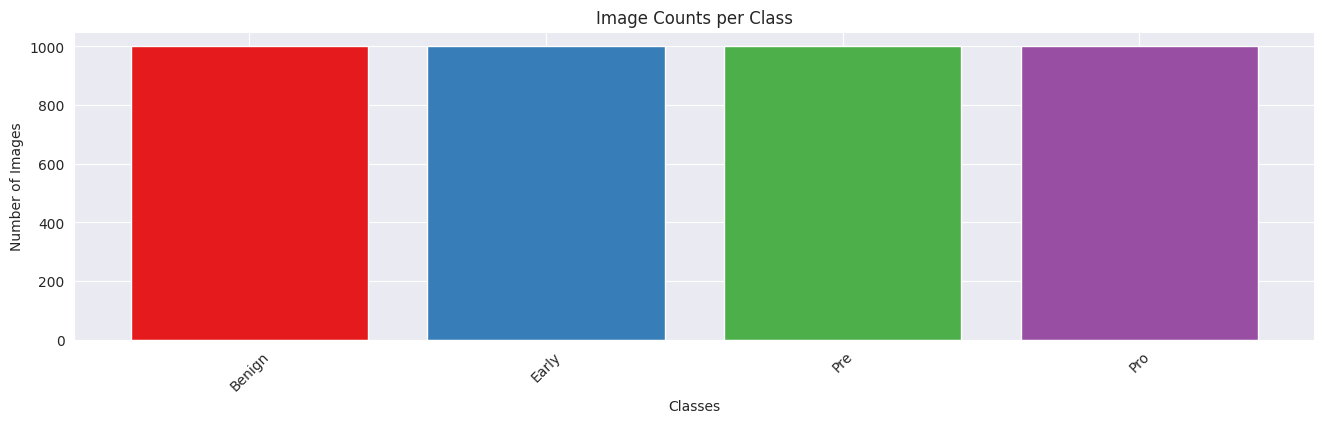

In [3]:
# Count images in each class
class_counts = {cls: sum([len(files) for r, d, files in os.walk(os.path.join(DATA_DIR, cls))]) for cls in CLASSES}
print("Original class counts:", class_counts)

# Plot class counts
classes = list(class_counts.keys())
counts = list(class_counts.values())

palette = sns.color_palette("Set1", len(classes))
plt.figure(figsize=(16, 4))
plt.bar(classes, counts, color=palette)
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.title('Image Counts per Class')
plt.xticks(rotation=45)
plt.show()

In [4]:
# Separate images by class
class_images = {class_name: [] for class_name in CLASSES}
class_labels = {class_name: [] for class_name in CLASSES}

for idx, class_name in enumerate(CLASSES):
    class_dir = os.path.join(DATA_DIR, class_name)
    for img_name in os.listdir(class_dir):
        img_path = os.path.join(class_dir, img_name)
        img = tf.keras.preprocessing.image.load_img(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
        img_array = tf.keras.preprocessing.image.img_to_array(img)
        class_images[class_name].append(img_array)
        class_labels[class_name].append(idx)

In [5]:
# Convert to arrays
for class_name in CLASSES:
    class_images[class_name] = np.array(class_images[class_name])
    class_labels[class_name] = np.array(class_labels[class_name])

In [6]:
# Create train, val, test sets for each class
train_images = []
train_labels = []
val_images = []
val_labels = []
test_images = []
test_labels = []

train_size = 700   # 70% for training
val_size =  150   # 15% for validation
test_size = 150   # 15% for testing

# Number of images per class (total 1000 per class)
total_images_per_class = train_size + val_size + test_size

# Create a dictionary for each set type (train, val, test) to store the counts
data_distribution = {
    'Train': [train_size] * len(CLASSES),
    'Validation': [val_size] * len(CLASSES),
    'Test': [test_size] * len(CLASSES)
}

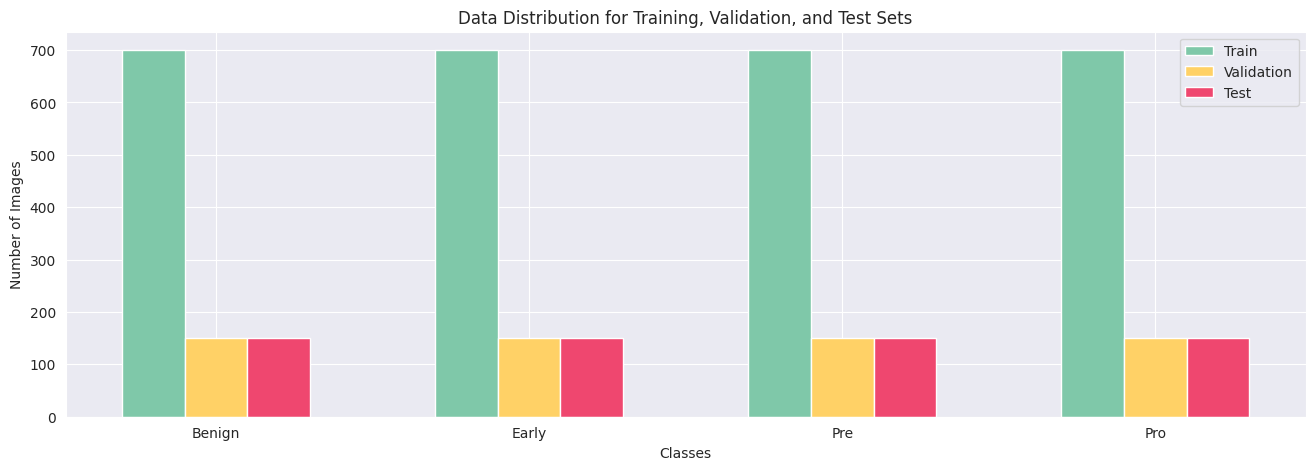

In [7]:
# Plotting the distribution
fig, ax = plt.subplots(figsize=(16, 5))

# Set up bar plot positions and width
bar_width = 0.2
positions_train = range(len(CLASSES))
positions_val = [p + bar_width for p in positions_train]
positions_test = [p + bar_width * 2 for p in positions_train]

# Plot the bars for train, val, and test sets
ax.bar(positions_train, data_distribution['Train'], width=bar_width, label='Train', color='#7FC8A9')
ax.bar(positions_val, data_distribution['Validation'], width=bar_width, label='Validation', color='#FFD166')
ax.bar(positions_test, data_distribution['Test'], width=bar_width, label='Test', color='#EF476F')

# Add some labels and a legend
ax.set_xlabel('Classes')
ax.set_ylabel('Number of Images')
ax.set_title('Data Distribution for Training, Validation, and Test Sets')
ax.set_xticks([p + bar_width for p in range(len(CLASSES))])
ax.set_xticklabels(CLASSES)
ax.legend()

# Show the plot
plt.show()

In [8]:
for class_name in CLASSES:
    imgs, lbls = shuffle(class_images[class_name], class_labels[class_name], random_state=123)
    
    # Assign train, val, test sets
    train_images.append(imgs[:train_size])
    train_labels.append(lbls[:train_size])
    
    val_images.append(imgs[train_size:train_size + val_size])
    val_labels.append(lbls[train_size:train_size + val_size])
    
    test_images.append(imgs[train_size + val_size:train_size + val_size + test_size])
    test_labels.append(lbls[train_size + val_size:train_size + val_size + test_size])

# Convert to numpy arrays
X_train = np.concatenate(train_images)
y_train = np.concatenate(train_labels)

X_val = np.concatenate(val_images)
y_val = np.concatenate(val_labels)

X_test = np.concatenate(test_images)
y_test = np.concatenate(test_labels)

# Normalize data
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

In [9]:
# Create datasets
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(1000).batch(BATCH_SIZE)
val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(BATCH_SIZE)
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(BATCH_SIZE)

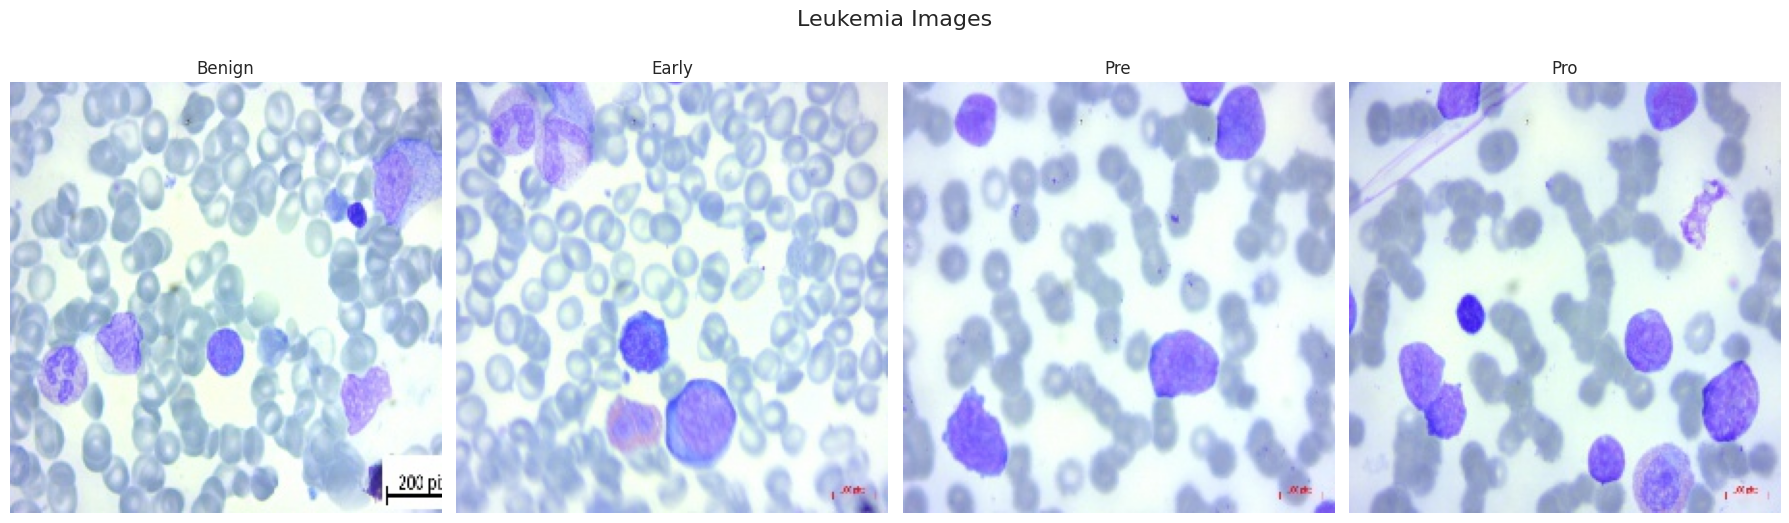

In [10]:
# Plot leukemia images
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(18, 5))
axes = axes.flatten()
fig.suptitle("Leukemia Images", fontsize=16, fontdict=dict(weight='bold'), y=1.04)

for curr_title, (image_tensor, label), curr_axis in zip(CLASSES, train_ds.take(4), axes[:4]):
    # Properly reshape and convert the image tensor
    curr_image = tf.squeeze(image_tensor)  # Remove batch dimension if present

    # Ensure the image is in the correct shape (height, width, channels)
    if len(curr_image.shape) == 4:  # If still 4D
        curr_image = curr_image[0]  # Remove extra dimension

    # Convert to numpy array and ensure uint8 data type with correct value range
    curr_image = curr_image.numpy()

    if curr_image.max() <= 1.0:
        curr_image = (curr_image * 255).astype(np.uint8)
    else:
        curr_image = curr_image.astype(np.uint8)

    # Create PIL Image and enhance brightness
    img_enhancer = PIL.ImageEnhance.Brightness(PIL.Image.fromarray(curr_image))
    curr_axis.imshow(img_enhancer.enhance(1))
    curr_axis.set_title(curr_title)
    curr_axis.axis('off')

plt.tight_layout()
plt.show()

# InceptionResNetV2

In [11]:
base_model = InceptionResNetV2(input_shape=IMG_SHAPE, weights='imagenet', include_top=False)
base_model.trainable = False

219055592/219055592 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ inception_resnet_v2             │ (None, 5, 5, 1536)     │    54,336,736 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1536)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       393,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 54,731,236 (208.78 MB)

 Trainable params: 394,500 (1.50 MB)

 Non-trainable params: 54,336,736 (207.28 MB)

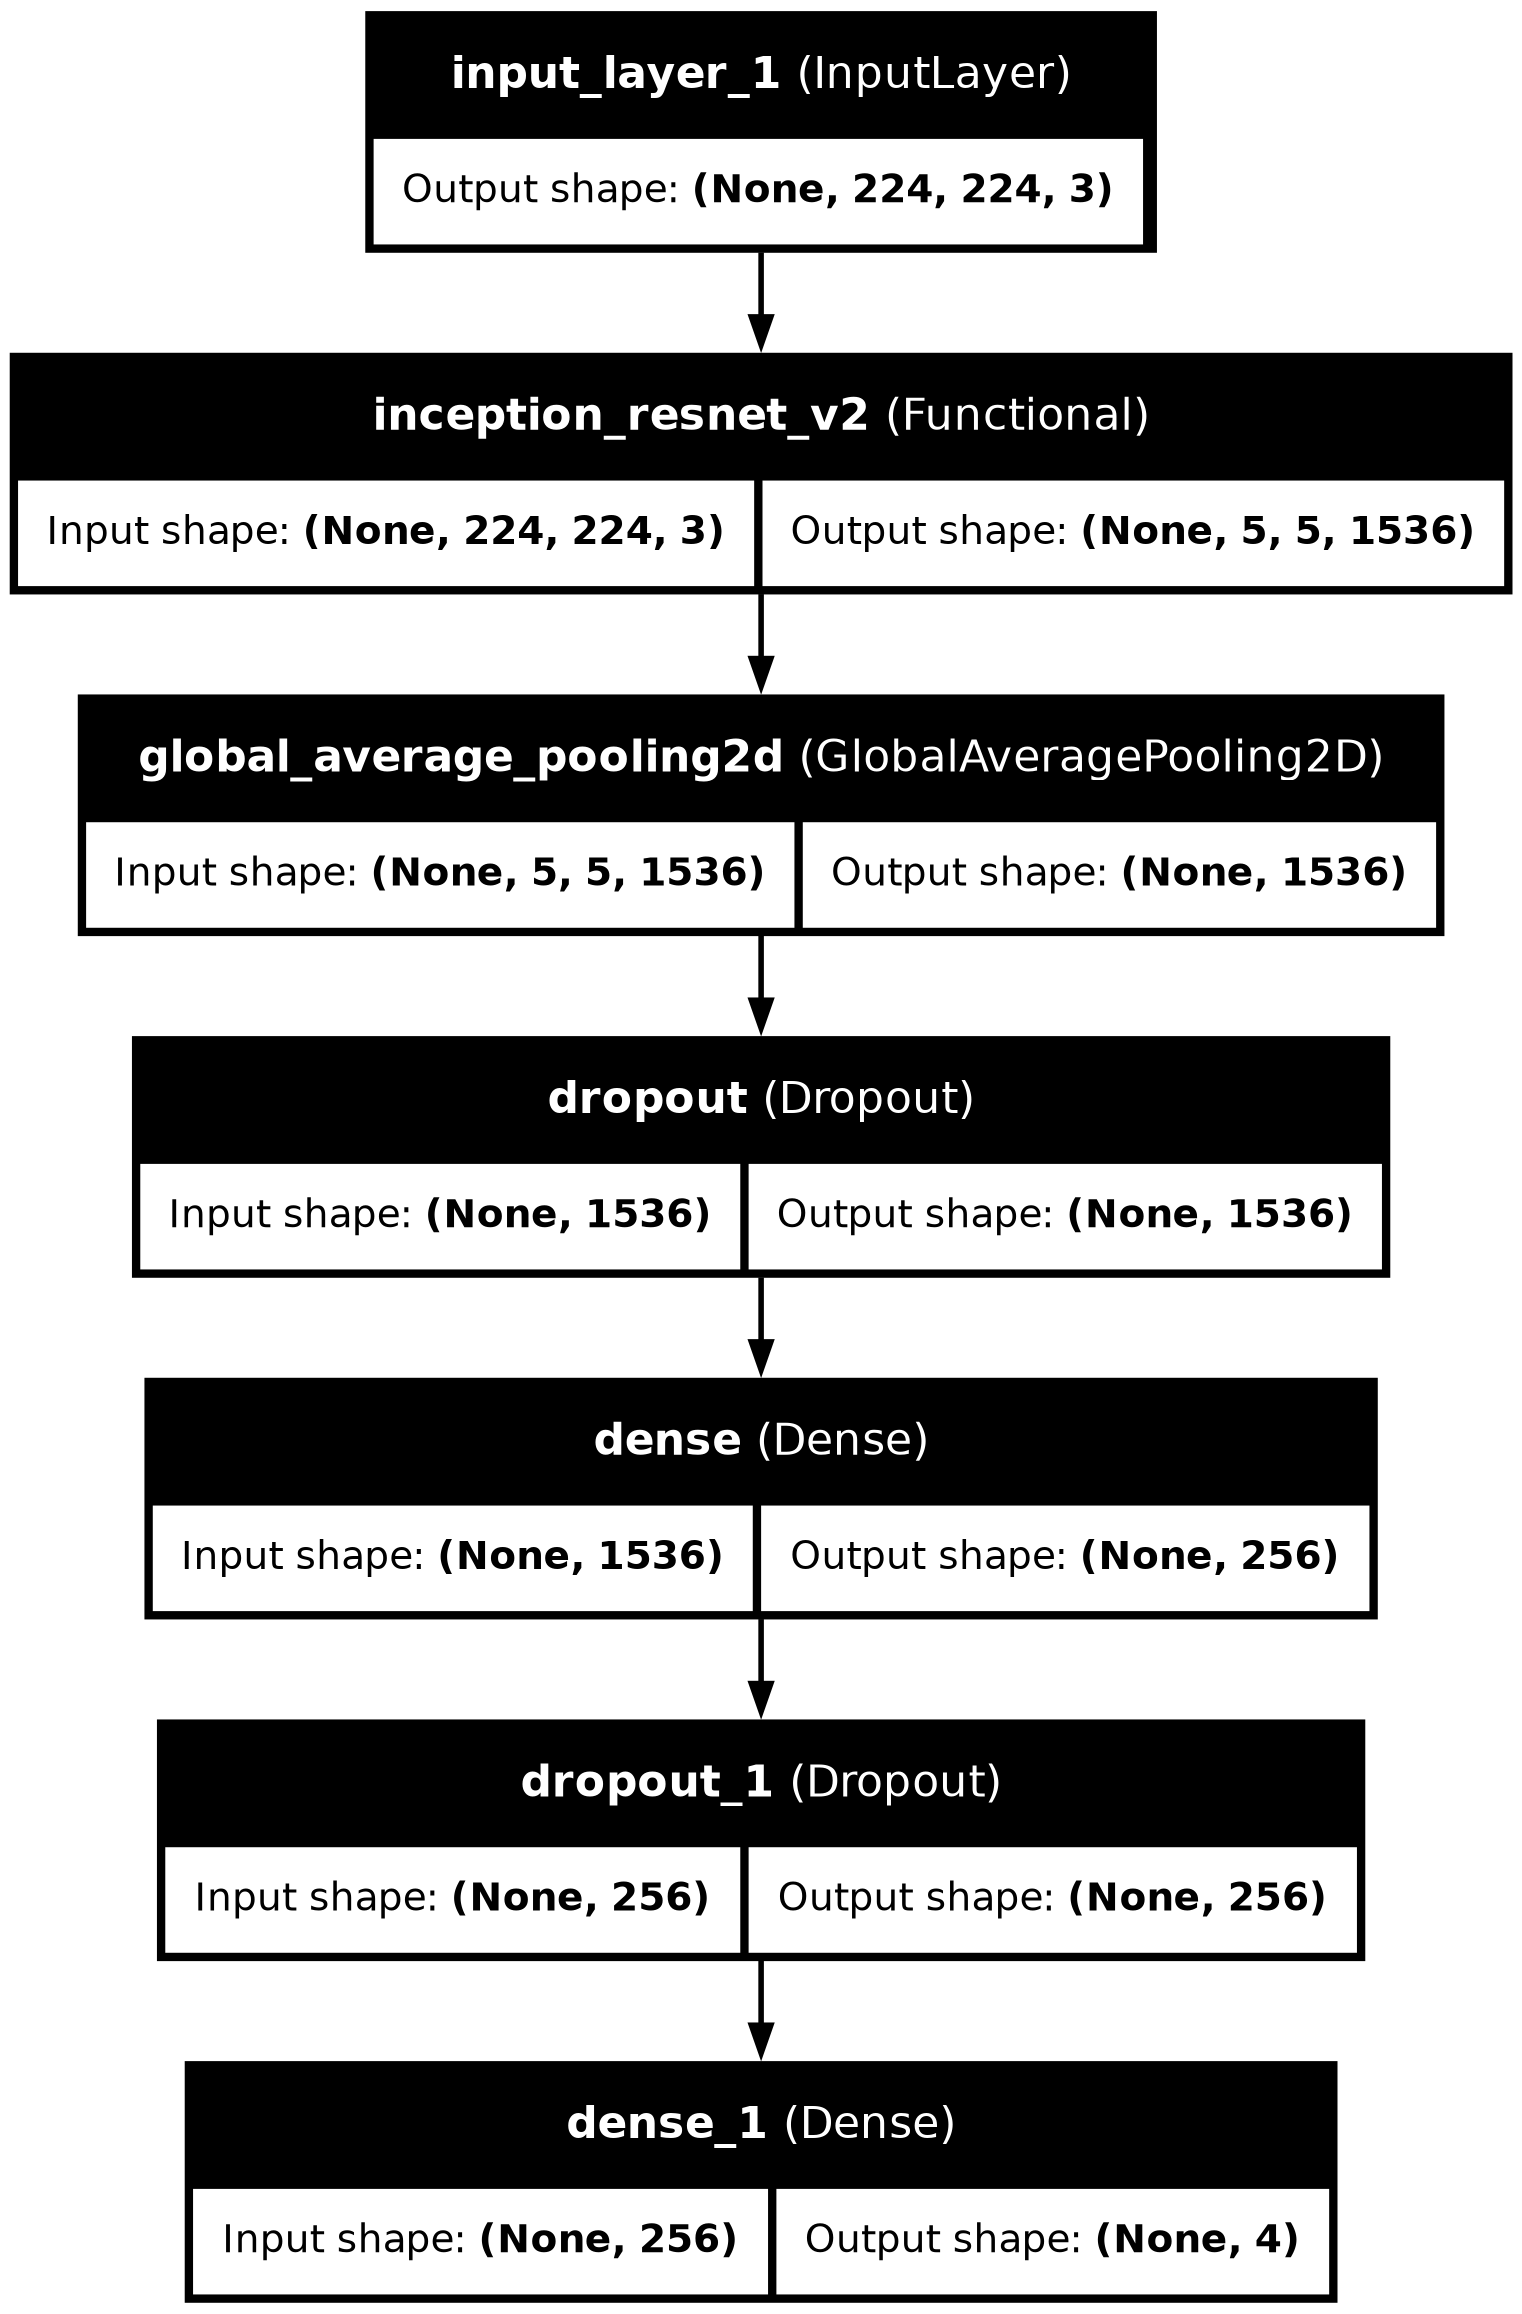

In [12]:
# Model architecture
inputs = Input(shape=IMG_SHAPE)
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(DROPOUT_RATE)(x)

# Additional dense layer
x = Dense(256, activation='relu')(x) 
x = Dropout(DROPOUT_RATE)(x)

# Output layer
outputs = Dense(len(CLASSES), activation='softmax')(x)

model = Model(inputs, outputs)
model.summary()

# Plot the model architecture
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

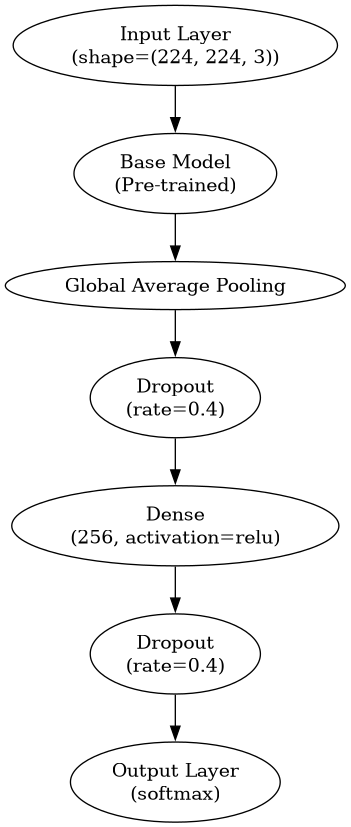

In [15]:
from IPython.display import Image

# Define the Graphviz code for your model architecture
dot = graphviz.Digraph(format='png')

# Add input layer
dot.node('Input', 'Input Layer\n(shape={})'.format(IMG_SHAPE))

# Add layers to the graph
dot.node('BaseModel', 'Base Model\n(Pre-trained)')
dot.node('GAP', 'Global Average Pooling')
dot.node('Dropout1', 'Dropout\n(rate={})'.format(DROPOUT_RATE))
dot.node('Dense1', 'Dense\n(256, activation=relu)')
dot.node('Dropout2', 'Dropout\n(rate={})'.format(DROPOUT_RATE))
dot.node('Output', 'Output Layer\n(softmax)')

# Define edges
dot.edge('Input', 'BaseModel')
dot.edge('BaseModel', 'GAP')
dot.edge('GAP', 'Dropout1')
dot.edge('Dropout1', 'Dense1')
dot.edge('Dense1', 'Dropout2')
dot.edge('Dropout2', 'Output')

# Render the graph and display it
dot.render('model_architecture', view=False)  # Saves the file but does not open it

# Display in notebook
Image('model_architecture.png')

In [23]:
import plotly.graph_objects as go
import tensorflow as tf
from tensorflow.keras import layers, models

# Create the 3D plot
def plot_model_3d(model):
    layers_info = []
    x_pos, y_pos, z_pos = [], [], []
    
    # Collect layer names and positions for plotting
    for idx, layer in enumerate(model.layers):
        layers_info.append(layer.name)
        x_pos.append(idx * 2)
        y_pos.append(0)
        z_pos.append(0)
    
    # Create 3D scatter plot for layer positions
    fig = go.Figure()

    # Add layers as points in 3D space
    fig.add_trace(go.Scatter3d(
        x=x_pos,
        y=y_pos,
        z=z_pos,
        mode='markers+text',
        text=layers_info,
        marker=dict(size=5, color='blue')
    ))

    # Add lines connecting layers
    for i in range(len(x_pos) - 1):
        fig.add_trace(go.Scatter3d(
            x=[x_pos[i], x_pos[i+1]],
            y=[y_pos[i], y_pos[i+1]],
            z=[z_pos[i], z_pos[i+1]],
            mode='lines',
            line=dict(color='black', width=2)
        ))

    # Adjust layout to show in 3D
    fig.update_layout(
        scene=dict(
            xaxis_title="Layer Index",
            yaxis_title="Y Position",
            zaxis_title="Z Position"
        ),
        title="3D Model Architecture"
    )

    # Show plot
    fig.show()

# Call function
plot_model_3d(model)

In [15]:
# Compile the model
optimizer = Adam(learning_rate=LEARNING_RATE)
optimizer = mixed_precision.LossScaleOptimizer(optimizer)

model.compile(
    optimizer=optimizer,
    loss=tf.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

# Define callbacks
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1),
    EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True),
    ModelCheckpoint(f'{EXPERIMENT_NAME}_best_model.keras', monitor='val_loss', save_best_only=True)
]

# Train the model
model_history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/60


I0000 00:00:1730471853.940539     114 service.cc:145] XLA service 0x79690d443240 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730471853.940594     114 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


 1/88 ━━━━━━━━━━━━━━━━━━━━ 1:03:10 44s/step - accuracy: 0.0938 - loss: 2.4185

I0000 00:00:1730471875.437436     114 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


88/88 ━━━━━━━━━━━━━━━━━━━━ 96s 599ms/step - accuracy: 0.3095 - loss: 1.5833 - val_accuracy: 0.2500 - val_loss: 1.3786 - learning_rate: 1.0000e-04
Epoch 2/60
88/88 ━━━━━━━━━━━━━━━━━━━━ 12s 141ms/step - accuracy: 0.2538 - loss: 1.5145 - val_accuracy: 0.3533 - val_loss: 1.2442 - learning_rate: 1.0000e-04
Epoch 3/60
88/88 ━━━━━━━━━━━━━━━━━━━━ 12s 142ms/step - accuracy: 0.3313 - loss: 1.3533 - val_accuracy: 0.4417 - val_loss: 1.1499 - learning_rate: 1.0000e-04
Epoch 4/60
88/88 ━━━━━━━━━━━━━━━━━━━━ 12s 142ms/step - accuracy: 0.4076 - loss: 1.2486 - val_accuracy: 0.4317 - val_loss: 1.0621 - learning_rate: 1.0000e-04
Epoch 5/60
88/88 ━━━━━━━━━━━━━━━━━━━━ 12s 142ms/step - accuracy: 0.4416 - loss: 1.2252 - val_accuracy: 0.4917 - val_loss: 0.9610 - learning_rate: 1.0000e-04
Epoch 6/60
88/88 ━━━━━━━━━━━━━━━━━━━━ 13s 147ms/step - accuracy: 0.4974 - loss: 1.0851 - val_accuracy: 0.6000 - val_loss: 0.8420 - learning_rate: 1.0000e-04
Epoch 7/60
88/88 ━━━━━━━━━━━━━━━━━━━━ 12s 141ms/step - accuracy: 0.55

# Results

In [16]:
# Make predictions on the validation dataset
predictions = model.predict(val_ds)

# Convert predictions from probabilities to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Get true labels from the validation dataset
true_labels = np.concatenate([y for x, y in val_ds], axis=0)

# Generate the classification report
report = classification_report(true_labels, predicted_labels, target_names=CLASSES)
print(report)

19/19 ━━━━━━━━━━━━━━━━━━━━ 24s 691ms/step
              precision    recall  f1-score   support

      Benign       0.96      0.94      0.95       150
       Early       0.95      0.97      0.96       150
         Pre       0.99      0.96      0.97       150
         Pro       0.97      0.99      0.98       150

    accuracy                           0.96       600
   macro avg       0.97      0.96      0.96       600
weighted avg       0.97      0.96      0.96       600



In [17]:
# Evaluate the model on the training data
train_loss, train_acc = model.evaluate(train_ds)
print(f"Training Loss: {train_loss}")
print(f"Training Accuracy: {train_acc}")

# Evaluate the model on the validation data
val_loss, val_acc = model.evaluate(val_ds)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_acc}")

# Evaluate the model on the test data
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_acc}")

88/88 ━━━━━━━━━━━━━━━━━━━━ 13s 148ms/step - accuracy: 0.9627 - loss: 0.1063
Training Loss: 0.07603082060813904
Training Accuracy: 0.9750000238418579
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - accuracy: 0.9473 - loss: 0.1347
Validation Loss: 0.09209863841533661
Validation Accuracy: 0.9649999737739563
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - accuracy: 0.9566 - loss: 0.1514
Test Loss: 0.1267203539609909
Test Accuracy: 0.9649999737739563


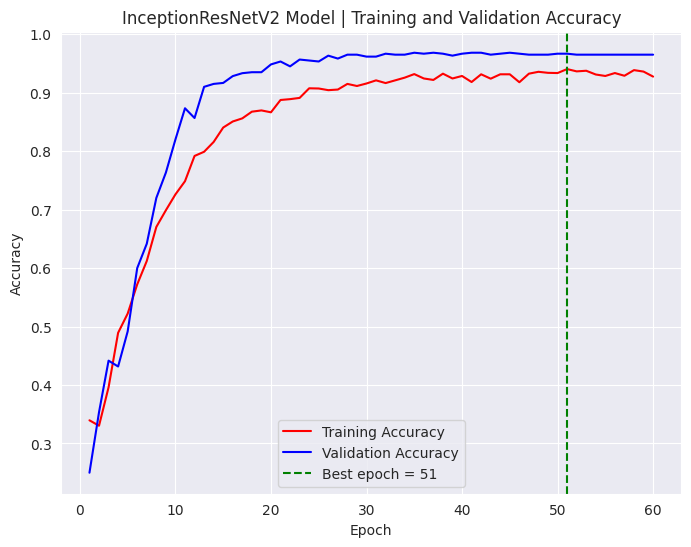

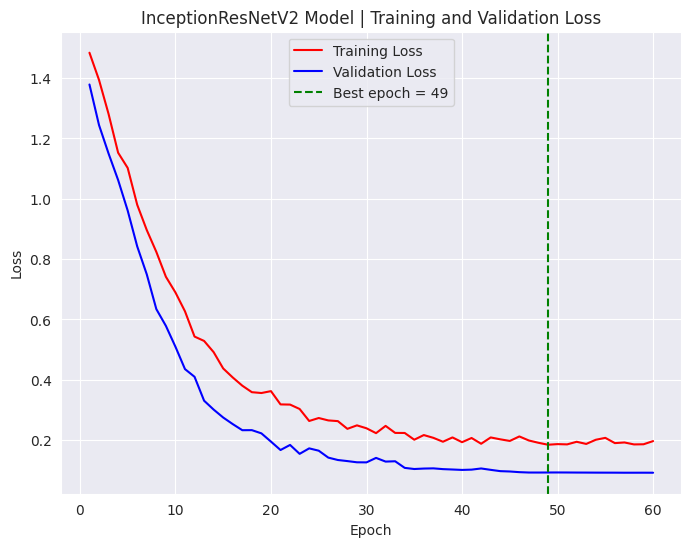

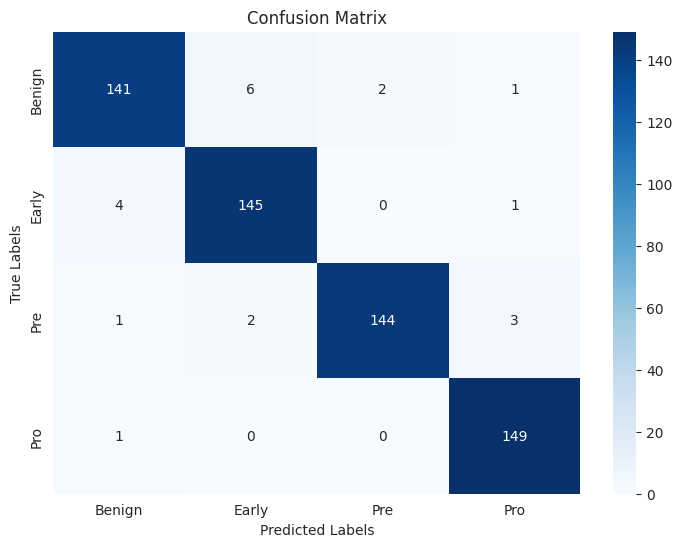

In [18]:
# Calculate best epochs
tr_acc = model_history.history['accuracy']
index_acc = np.argmax(tr_acc)  # Find epoch with highest training accuracy
index_loss = np.argmin(model_history.history['loss'])  # Find epoch with lowest training loss

# Plot accuracy and loss curves
acc = model_history.history['accuracy']
val_acc = model_history.history['val_accuracy']
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
Epochs = [i+1 for i in range(len(tr_acc))]

# Accuracy plot
plt.figure(figsize=[8, 6])
plt.plot(Epochs, acc, 'r', label='Training Accuracy')
plt.plot(Epochs, val_acc, 'b', label='Validation Accuracy')
plt.axvline(x=index_acc + 1, color='g', linestyle='--', label=f'Best epoch = {index_acc + 1}')
plt.title('InceptionResNetV2 Model | Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Loss plot
plt.figure(figsize=[8, 6])
plt.plot(Epochs, loss, 'r', label='Training Loss')
plt.plot(Epochs, val_loss, 'b', label='Validation Loss')
plt.axvline(x=index_loss + 1, color='g', linestyle='--', label=f'Best epoch = {index_loss + 1}')
plt.title('InceptionResNetV2 Model | Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Generate and plot the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8.5, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=CLASSES, yticklabels=CLASSES)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('InceptionResNetV2 Model Confusion Matrix')
plt.show()

19/19 ━━━━━━━━━━━━━━━━━━━━ 23s 675ms/step


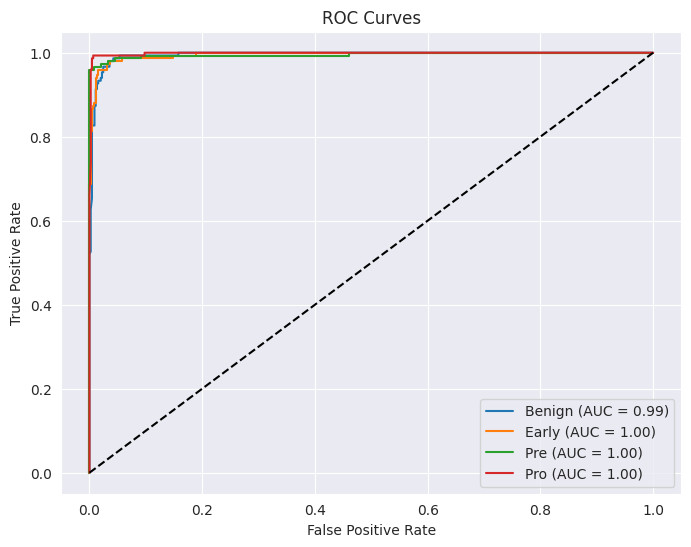

In [19]:
# Plot ROC Curves
plt.figure(figsize=(8, 6))
y_pred_proba = model.predict(X_test)
for i in range(len(CLASSES)):
    fpr, tpr, _ = roc_curve(y_test == i, y_pred_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{CLASSES[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('InceptionResNetV2 Model ROC Curves')
plt.legend()
plt.show()